<a href="https://colab.research.google.com/github/ljsonnanburg/Movie-Recommendation-System/blob/main/Movie_Review_Sentiment_Analysis_and_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Scraper

Below is our scraper to make a a series of API requests from IMDB and collect data for our project. Our example data set uses the top 1000 most popular movies based on recent activity on IMDB. To summarize what it's doing:
Given a page of movie search results found through https://www.imdb.com/search/title/?ref_=fn_asr_tt, it collects general data about the movie and and about one "helpful positive", one "helpful negative", one "unhelpful positive", and one "unhelpful negative" review.

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import itertools

In [ ]:
# Function for mass soup production
def createSoup(url):
    r = requests.get(url)
    data = r.text
    
    return BeautifulSoup(data)
#soup = createSoup('https://www.imdb.com/search/title/?groups=top_1000&languages=en')

# Finding Movies

In [ ]:
# expects soup of movie search results url
def find_movie_tags(soup):
  # Movies have a tags with class None
  # Finding all such tags
  movie_tags = soup.find_all('a', attrs={'class': None})
  # List comprehension voodoo to filter just the tags that fit the pattern of movie urls, ex: <a href="/title/tt11083552/?ref_=adv_li_i">
  movie_tags = [tag.attrs['href'] for tag in movie_tags if tag.attrs['href'].startswith('/title') & tag.attrs['href'].endswith('/')]

  # Removing duplicates
  movie_tags = list(set(movie_tags))
  return movie_tags

# Fetching Reviews


In [ ]:
def get_review_pages(movie_tags):
  # This takes a while 
  ordered_reviews_list = [getReviews(tag) for tag in movie_tags] 
  unpacked_reviews = list(sum(ordered_reviews_list, ()))
  return unpacked_reviews

In [ ]:
# Returns indicies for high and low ratings 
def highsAndLows(a):
  high = a.index(max(a))
  low = a.index(min(a))
  return high, low

# pass tags from movie_tags
def firstPageReviews(tag):
  url = 'https://www.imdb.com' + tag + 'reviews'
  soup = createSoup(url)
  # Get list of star ratings
  user_review_ratings = [tag.previous_element for tag in 
                           soup.find_all('span', attrs={'class': 'point-scale'})]
  # Get review tags
  user_review_tags = soup.find_all('a', attrs={'class':'title'})
  #print(user_review_tags)

  # Finds indices for highest and lowest ratings 
  high_ind, low_ind = highsAndLows(list(map(int, user_review_ratings)))
  #high_ind = user_review_ratings.index(max(user_review_ratings))
  #low_ind = user_review_ratings.index(min(user_review_ratings))

  # Get tags for positive and negative reviews
  pos_tag = user_review_tags[high_ind]
  neg_tag = user_review_tags[low_ind]
    
  #print(pos_tag['href'])
  # return the negative and positive review link
  pos_link = 'https://www.imdb.com' + pos_tag['href']
  neg_link = 'https://www.imdb.com' + neg_tag['href']

  return pos_link, neg_link

# Returns VERY HIGH and VERY LOW ratings. Presumably these will always be 10/10, 1/10, and very 'unhelpful'.
def bestWorst(tag):
  best_url = 'https://www.imdb.com' + tag + 'reviews?sort=userRating&dir=desc&ratingFilter=0'
  best_soup = createSoup(best_url)
  best_url = 'https://www.imdb.com' + (best_soup.find('a', attrs={'class':'title'}))['href']

  worst_url = 'https://www.imdb.com' + tag + 'reviews?sort=userRating&dir=asc&ratingFilter=0'
  worst_soup = createSoup(worst_url)
  worst_url = 'https://www.imdb.com' + (worst_soup.find('a', attrs={'class':'title'}))['href']

  return best_url, worst_url

# Returns tuple containing, in order: Helpful high rating, helpful low rating, unhelpful high rating, unhelpful low rating
def getReviews(tag):
  helpful_high, helpful_low = firstPageReviews(tag)
  
  high, low = bestWorst(tag)

  ordered_reviews = (helpful_high,helpful_low,high,low)
  #print(ordered_reviews)
  return ordered_reviews

# Getting Review Information

In [ ]:
# returns review text
def getText(url):
    # Get soup for review's page
    soup = createSoup(url)
    
    # Find review text tag
    tag = soup.find('div', attrs={'class': 'text show-more__control'})
    
    return tag.getText()

# returns movie title
def getTitle(url):
    # Get soup for review's page
    soup = createSoup(url)
    
    # Find title tag
    tag = soup.find('h1')
    
    #print(list(tag.children)[1].getText())
    return list(tag.children)[1].getText()

# Getting General Movie Information

In [ ]:
# Takes list of tages from scrape_results_page
# returns dataframe of attributes of movies listed on that page
def get_movie_data(tag_list):
  # initializing lists that later become dataframe
  titles_list = []
  genres_list = []
  plots_list = []
  ratings_list = []
  # loop to get data from each tag
  for tag in tag_list:
    # builds url form tag
    url = 'https://www.imdb.com' + tag
    movie_soup = createSoup(url) # creates soup object for current movie page
    # gets genre list
    genres = movie_soup.findAll('a', attrs={'class': 'ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link' })

    # gets movie title
    movie_title = movie_soup.find('h1').text
    titles_list.append(movie_title)
    
    movie_genres = []
    for genre in genres:
      if('genre' in genre.attrs['href']):
        movie_genres.append(genre.text)
    
    # gets movie rating
    movie_rating = movie_soup.find('span', attrs={'class': 'AggregateRatingButton__RatingScore-sc-1il8omz-1 fhMjqK' }).text
    ratings_list.append(movie_rating)
    # gets text of movie plot
    movie_plot = movie_soup('div', attrs={'class': 'ipc-html-content ipc-html-content--base'})[0].text
    plots_list.append(movie_plot)
    # stringifies genres
    movie_genres = ', '.join(movie_genres)
    genres_list.append(movie_genres)
  
  # builds dataframe of data for movies from results page
  movie_df = pd.DataFrame({'title': titles_list, 'genre': genres_list, 'plot': plots_list, 'rating': ratings_list})

  return(movie_df)




#get_movie_data(['/title/tt4016934/'])

# Scraper Function
Directs the other functions to scrape data for all searched movie results

In [ ]:
# pass this the url of a movie search results page and it does the rest
def scrape_results_page(url):
  soup = createSoup(url) # creates soup object of search results
  movie_tags = soup.find_all('a', attrs={'class': None}) # collects tags that lead to moview urls
  # List comprehension voodoo to filter just the tags that fit the pattern of movie urls, e.g.: <a href="/title/tt11083552/?ref_=adv_li_i">
  movie_tags = [tag.attrs['href'] for tag in movie_tags if tag.attrs['href'].startswith('/title') & tag.attrs['href'].endswith('/')]

  
  movie_tags = list(set(movie_tags)) # Removing duplicates
  movie_df = get_movie_data(movie_tags) # Retrieves dataframe of movie attributes

  unpacked_reviews = get_review_pages(movie_tags) # collects pages of desired reviews
  review_texts = [getText(url) for url in unpacked_reviews] # collects text of reviews from those pages
  movie_titles = [getTitle(url) for url in unpacked_reviews] # collects titles of the movies reviewed
  # this code's gone under so many revisions, I'm pretty sure this is redundant but I'm afraid to change anything because it takes > 1 hour to test
  ordered_reviews_list = [getTitle(url) for url in unpacked_reviews] 
  # generates column of labels for review sentiments
  review_sentiment = np.array(['helpful positive', 'helpful negative', 'unhelpful positive', 'unhelpful negative'] * (len(ordered_reviews_list)//4))
  # creates dataframe of reviews
  review_df = pd.DataFrame({'url': unpacked_reviews, 'title': movie_titles, 'review': review_texts, 'sentiment': review_sentiment})
  return review_df, movie_df

# Function Calls
Applying the scraper to the top 1000 movies on IMDB. IMDB only shows 250 maximum results on a single page, so we need to call it 4 times.

In [ ]:
# function calls to get data frames for each page of 250 movie listings
review_df1, movie_df1 = scrape_results_page('https://www.imdb.com/search/title/?groups=top_1000&count=250')
review_df2, movie_df2 = scrape_results_page('https://www.imdb.com/search/title/?groups=top_1000&count=250&start=251&ref_=adv_nxt')
review_df3, movie_df3 = scrape_results_page('https://www.imdb.com/search/title/?groups=top_1000&count=250&start=501&ref_=adv_nxt')
review_df4, movie_df4 = scrape_results_page('https://www.imdb.com/search/title/?groups=top_1000&count=250&start=751&ref_=adv_nxt')

# Constructing the Dataframe

In [ ]:
# combining all the data
df1 = review_df1.merge(movie_df1, left_on='title', right_on='title')
df2 = review_df2.merge(movie_df2, left_on='title', right_on='title')
df3 = review_df3.merge(movie_df3, left_on='title', right_on='title')
df4 = review_df4.merge(movie_df4, left_on='title', right_on='title')

In [ ]:
full_df = df1.append(df2, ignore_index=True).append(df3, ignore_index=True).append(df4, ignore_index=True)
full_df

,url,title,review,sentiment,genre,plot,rating
0,https://www.imdb.com/review/rw0213795/,Once Upon a Time in America,"Many people compare ""Once Upon a Time in Ameri...",helpful positive,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4
1,https://www.imdb.com/review/rw2900651/,Once Upon a Time in America,... Directors of all time. Let's start with a ...,helpful negative,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4
2,https://www.imdb.com/review/rw1324424/,Once Upon a Time in America,Simply the best movie ever made. Dot.Life. Lov...,unhelpful positive,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4
3,https://www.imdb.com/review/rw0213775/,Once Upon a Time in America,Once Upon a Time in America is Sergio Leone's ...,unhelpful negative,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4
4,https://www.imdb.com/review/rw6164695/,American Psycho,The author of the novel and the director of th...,helpful positive,"Comedy, Crime, Drama",It's the late 1980s. Twenty-seven year old Wal...,7.6
...,...,...,...,...,...,...,...
3995,https://www.imdb.com/review/rw0293026/,Delicatessen,I'm going to go against what virtually everyon...,unhelpful negative,"Comedy, Crime",Centered on a post-apocalyptic society where f...,7.6
3996,https://www.imdb.com/review/rw2375880/,Elite Squad 2: The Enemy Within,"I'll say one thing right off the bat, this mov...",helpful positive,"Action, Crime, Drama, Thriller",After a bloody invasion of the BOPE in the Hig...,8.0
3997,https://www.imdb.com/review/rw2325862/,Elite Squad 2: The Enemy Within,This movie has a message every Brazilian shoul...,helpful negative,"Action, Crime, Drama, Thriller",After a bloody invasion of the BOPE in the Hig...,8.0
3998,https://www.imdb.com/review/rw4358713/,Elite Squad 2: The Enemy Within,There is something so beautiful in the craft t...,unhelpful positive,"Action, Crime, Drama, Thriller",After a bloody invasion of the BOPE in the Hig...,8.0


# Saving the Dataframe
Because you don't want to need to run this program more than once.

In [ ]:
from google.colab import files
full_df.to_csv('IMDB_reviews.csv') 
files.download('IMDB_reviews.csv') # commented out so it doesn't surprise download on your computer

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparation

In [ ]:
# Reviewdata = full_df # ONLY UNCOMMENT if you want to test all of the above code, otherwise use the provided file

# Local directory
Reviewdata = pd.read_csv('IMDB_reviews.csv')
Reviewdata.drop(['Unnamed: 0', 'url'], axis=1, inplace=True)

In [ ]:
Reviewdata.shape

(4000, 6)

In [ ]:
Reviewdata.head()

,title,review,sentiment,genre,plot,rating
0,Once Upon a Time in America,"Many people compare ""Once Upon a Time in Ameri...",helpful positive,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4
1,Once Upon a Time in America,... Directors of all time. Let's start with a ...,helpful negative,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4
2,Once Upon a Time in America,Simply the best movie ever made. Dot.Life. Lov...,unhelpful positive,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4
3,Once Upon a Time in America,Once Upon a Time in America is Sergio Leone's ...,unhelpful negative,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4
4,American Psycho,The author of the novel and the director of th...,helpful positive,"Comedy, Crime, Drama",It's the late 1980s. Twenty-seven year old Wal...,7.6


In [ ]:
Reviewdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      4000 non-null   object 
 1   review     4000 non-null   object 
 2   sentiment  4000 non-null   object 
 3   genre      4000 non-null   object 
 4   plot       4000 non-null   object 
 5   rating     4000 non-null   float64
dtypes: float64(1), object(5)
memory usage: 187.6+ KB


In [ ]:
Reviewdata.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rating,4000.0,7.9566,0.277337,7.6,7.7,7.9,8.1,9.3


# Data Cleaning/EDA

In [ ]:
### Checking Missing values in the Data Set and printing the Percentage for Missing Values for Each Columns ###

count = Reviewdata.isnull().sum().sort_values(ascending=False)
percentage = ((Reviewdata.isnull().sum()/len(Reviewdata)*100)).sort_values(ascending=False)
missing_data = pd.concat([count, percentage], axis=1,
keys=['Count','Percentage'])

print('Count and percentage of missing values for the columns:')

missing_data

Count and percentage of missing values for the columns:


,Count,Percentage
rating,0,0.0
plot,0,0.0
genre,0,0.0
sentiment,0,0.0
review,0,0.0
title,0,0.0


Percentage for default

unhelpful negative    25.0
helpful positive      25.0
unhelpful positive    25.0
helpful negative      25.0
Name: sentiment, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  del sys.path[0]


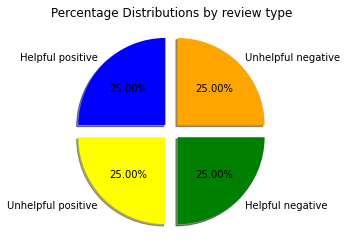

In [ ]:
### Checking for the Distribution of Default ###
import matplotlib.pyplot as plt
%matplotlib inline
print('Percentage for default\n')
print(round(Reviewdata.sentiment.value_counts(normalize=True)*100,2))
#round(Reviewdata.sentiment.value_counts(normalize=True)*100,2).plot(kind='pie')
import matplotlib.pyplot as plt

labels= ['Helpful positive', 'Unhelpful positive', 'Helpful negative', 'Unhelpful negative']
colors=['blue', 'yellow', 'green', 'orange']
sizes= [round(Reviewdata.sentiment.value_counts(normalize=True)*100,2)]

plt.pie(sizes,labels=labels, colors=colors, startangle=90, shadow=True,explode=(0.1, 0.1, 0.1, 0.1), autopct='%1.2f%%')
plt.title('Percentage Distributions by review type')
plt.show()

In [ ]:
import re
from string import punctuation
from textblob import TextBlob
from nltk import stem
from nltk.corpus import stopwords
import nltk
nltk.download('all')
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
import sys
!{sys.executable} -m pip install autocorrect
from autocorrect import Speller

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

In [ ]:
# Apply first level cleaning

contraction_patterns=[(r'can\'t', 'can not'),
                    (r'haven\'t', 'have not'),
                    (r'wasn\'t', 'was not'),
                    (r'(\w+)\'ll', '\g<1> will'),
                    (r'(\w+)\'re', '\g<1> are'),
                     (r'don\'t', 'do not'),
                     (r'I\'m','I am')]

class contraction_replacer(object):
    def __init__(self, contraction_patterns):        
        # store compiled regex object
        self._contraction_regexes = [(re.compile(p), replaced_text) for p, replaced_text in contraction_patterns]
        
    def do_contraction_normalization(self, text):
        for contraction_regex, replaced_text in self._contraction_regexes:
            text = contraction_regex.sub(replaced_text, text)
        return text     

sample_contraction_replacer = contraction_replacer(contraction_patterns)

#This function converts to lower-case, removes square bracket, removes numbers and punctuation
def text_clean_1(text):
    #contraction
    contraction = sample_contraction_replacer.do_contraction_normalization(text)
    p = ''.join(c for c in contraction if c not in punctuation)
    #Lower case
    L =p.lower()
    #tokenize
    tokenize = nltk.word_tokenize(L)
    #remove stop words
    stop_w = stopwords.words('english')
    lst = [w for w in tokenize if w not in stop_w]     
    new_text = ' '.join(lst)  
    return new_text

cleaned1 = lambda x: text_clean_1(x)

In [ ]:
# Let's take a look at the updated text
Reviewdata['review_clean'] = pd.DataFrame(Reviewdata.review.apply(cleaned1))
Reviewdata.head(10)

,title,review,sentiment,genre,plot,rating,review_clean
0,Once Upon a Time in America,"Many people compare ""Once Upon a Time in Ameri...",helpful positive,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4,many people compare upon time america godfathe...
1,Once Upon a Time in America,... Directors of all time. Let's start with a ...,helpful negative,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4,directors time lets start story many years ago...
2,Once Upon a Time in America,Simply the best movie ever made. Dot.Life. Lov...,unhelpful positive,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4,simply best movie ever made dotlife love frien...
3,Once Upon a Time in America,Once Upon a Time in America is Sergio Leone's ...,unhelpful negative,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4,upon time america sergio leones epic tale live...
4,American Psycho,The author of the novel and the director of th...,helpful positive,"Comedy, Crime, Drama",It's the late 1980s. Twenty-seven year old Wal...,7.6,author novel director film say head yuppies dr...
5,American Psycho,This is a frightening and wildly satiric look ...,helpful negative,"Comedy, Crime, Drama",It's the late 1980s. Twenty-seven year old Wal...,7.6,frightening wildly satiric look mentality high...
6,American Psycho,I think this is the best adaptation of a Bret ...,unhelpful positive,"Comedy, Crime, Drama",It's the late 1980s. Twenty-seven year old Wal...,7.6,think best adaptation bret eston elliss book m...
7,American Psycho,"This movie is sick, pointless and utterly bori...",unhelpful negative,"Comedy, Crime, Drama",It's the late 1980s. Twenty-seven year old Wal...,7.6,movie sick pointless utterly boring message sh...
8,The Notebook,"In all honesty, my Dad paid me to go see the N...",helpful positive,"Drama, Romance","In a nursing home, resident Duke reads a roman...",7.8,honesty dad paid go see notebook friends kept ...
9,The Notebook,"Heartwarming, heart-wrenching, poignant, emoti...",helpful negative,"Drama, Romance","In a nursing home, resident Duke reads a roman...",7.8,heartwarming heartwrenching poignant emotional...


In [ ]:
# Apply a second round of cleaning

def text_clean_2(text):
    #spellchecker
    from autocorrect import Speller
    tokenize = nltk.word_tokenize(text)

    spell = Speller(lang='en')
    result = [spell(x) for x in tokenize]
    new_text = ' '.join(result) 
    return new_text

cleaned2 = lambda x: text_clean_2(x)

Positive words are as follows


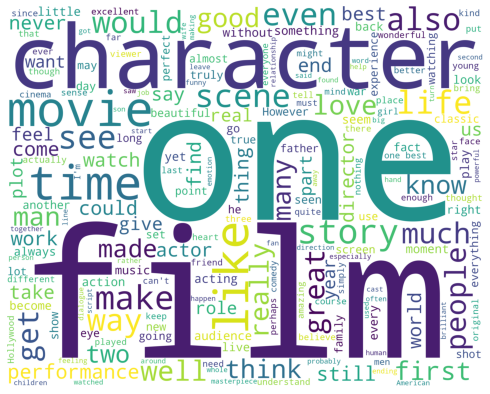

Negative words are as follows


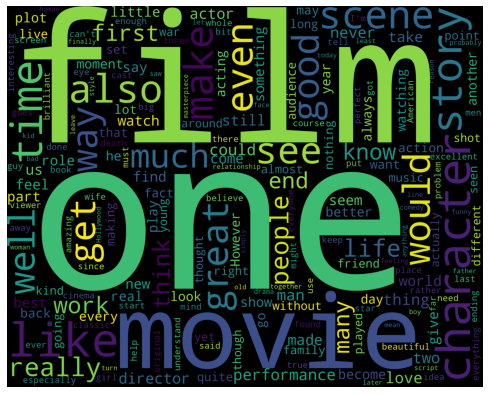

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


positivedata = Reviewdata[ Reviewdata['sentiment'] == 'helpful positive']
positivedata =positivedata['review']
negdata = Reviewdata[ Reviewdata['sentiment'] == 'helpful negative']
negdata= negdata['review']

def wordcloud_draw(data, color = 'white'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                              if(word!='movie' and word!='film')
                            ])
    wordcloud = WordCloud(stopwords=stopwords.words('english'),
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(10, 7))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words are as follows")
wordcloud_draw(positivedata,'white')
print("Negative words are as follows")
wordcloud_draw(negdata, 'black')

In [ ]:

Reviewdata['sentiment']=Reviewdata['sentiment'].replace(['helpful positive','unhelpful positive'], 'positive')
Reviewdata['sentiment']=Reviewdata['sentiment'].replace(['helpful negative','unhelpful negative'], 'negative')

Reviewdata.head(10)

,title,review,sentiment,genre,plot,rating,review_clean
0,Once Upon a Time in America,"Many people compare ""Once Upon a Time in Ameri...",positive,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4,many people compare upon time america godfathe...
1,Once Upon a Time in America,... Directors of all time. Let's start with a ...,negative,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4,directors time lets start story many years ago...
2,Once Upon a Time in America,Simply the best movie ever made. Dot.Life. Lov...,positive,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4,simply best movie ever made dotlife love frien...
3,Once Upon a Time in America,Once Upon a Time in America is Sergio Leone's ...,negative,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4,upon time america sergio leones epic tale live...
4,American Psycho,The author of the novel and the director of th...,positive,"Comedy, Crime, Drama",It's the late 1980s. Twenty-seven year old Wal...,7.6,author novel director film say head yuppies dr...
5,American Psycho,This is a frightening and wildly satiric look ...,negative,"Comedy, Crime, Drama",It's the late 1980s. Twenty-seven year old Wal...,7.6,frightening wildly satiric look mentality high...
6,American Psycho,I think this is the best adaptation of a Bret ...,positive,"Comedy, Crime, Drama",It's the late 1980s. Twenty-seven year old Wal...,7.6,think best adaptation bret eston elliss book m...
7,American Psycho,"This movie is sick, pointless and utterly bori...",negative,"Comedy, Crime, Drama",It's the late 1980s. Twenty-seven year old Wal...,7.6,movie sick pointless utterly boring message sh...
8,The Notebook,"In all honesty, my Dad paid me to go see the N...",positive,"Drama, Romance","In a nursing home, resident Duke reads a roman...",7.8,honesty dad paid go see notebook friends kept ...
9,The Notebook,"Heartwarming, heart-wrenching, poignant, emoti...",negative,"Drama, Romance","In a nursing home, resident Duke reads a roman...",7.8,heartwarming heartwrenching poignant emotional...


# Model Training

In [ ]:
from sklearn.model_selection import train_test_split

Independent_var = Reviewdata.review_clean
Dependent_var = Reviewdata.sentiment

IV_train, IV_test, DV_train, DV_test = train_test_split(Independent_var, Dependent_var, test_size = 0.1, random_state = 225)

print('IV_train :', len(IV_train))
print('IV_test  :', len(IV_test))
print('DV_train :', len(DV_train))
print('DV_test  :', len(DV_test))


IV_train : 3600
IV_test  : 400
DV_train : 3600
DV_test  : 400


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tvec = TfidfVectorizer()
clf2 = LogisticRegression(solver = "lbfgs")


from sklearn.pipeline import Pipeline

In [ ]:
model = Pipeline([('vectorizer',tvec),('classifier',clf2)])

model.fit(IV_train, DV_train)


from sklearn.metrics import confusion_matrix

predictions = model.predict(IV_test)

confusion_matrix(predictions, DV_test)

array([[133,  46],
       [ 63, 158]])

# Model Prediction

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Accuracy : ", accuracy_score(predictions, DV_test))
print("Precision : ", precision_score(predictions, DV_test, average = 'weighted'))
print("Recall : ", recall_score(predictions, DV_test, average = 'weighted'))

Accuracy :  0.7275
Precision :  0.731577380952381
Recall :  0.7275


# Trying on New Reviews

In [ ]:
example = ["awesome"]
result = model.predict(example)

print(result)

['positive']


In [ ]:
#this takes almost 10 mnts to execute
reviews =Reviewdata['review_clean']
print(len(reviews))
flag = 0
positive_count=[]
negative_count=[]
while flag != len(reviews):
  count = 0
  ncount = 0
  for word in reviews[flag].split(' '):
    b = model.predict([word])
    if b == 'positive':
      count +=1
    else:
      ncount +=1
  flag +=1
  positive_count.append(count)
  negative_count.append(ncount)

Reviewdata['Positive_count'] = positive_count
Reviewdata['Negative_count'] = negative_count


4000


In [ ]:
Reviewdata

,title,review,sentiment,genre,plot,rating,review_clean,Positive_count,Negative_count
0,Once Upon a Time in America,"Many people compare ""Once Upon a Time in Ameri...",positive,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4,many people compare upon time america godfathe...,77,162
1,Once Upon a Time in America,... Directors of all time. Let's start with a ...,negative,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4,directors time lets start story many years ago...,81,250
2,Once Upon a Time in America,Simply the best movie ever made. Dot.Life. Lov...,positive,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4,simply best movie ever made dotlife love frien...,28,50
3,Once Upon a Time in America,Once Upon a Time in America is Sergio Leone's ...,negative,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4,upon time america sergio leones epic tale live...,88,334
4,American Psycho,The author of the novel and the director of th...,positive,"Comedy, Crime, Drama",It's the late 1980s. Twenty-seven year old Wal...,7.6,author novel director film say head yuppies dr...,14,36
...,...,...,...,...,...,...,...,...,...
3995,Delicatessen,I'm going to go against what virtually everyon...,negative,"Comedy, Crime",Centered on a post-apocalyptic society where f...,7.6,going go virtually everyone else said emperor ...,4,27
3996,Elite Squad 2: The Enemy Within,"I'll say one thing right off the bat, this mov...",positive,"Action, Crime, Drama, Thriller",After a bloody invasion of the BOPE in the Hig...,8.0,say one thing right bat movie incredible saw p...,26,51
3997,Elite Squad 2: The Enemy Within,This movie has a message every Brazilian shoul...,negative,"Action, Crime, Drama, Thriller",After a bloody invasion of the BOPE in the Hig...,8.0,movie message every brazilian think problem br...,11,43
3998,Elite Squad 2: The Enemy Within,There is something so beautiful in the craft t...,positive,"Action, Crime, Drama, Thriller",After a bloody invasion of the BOPE in the Hig...,8.0,something beautiful craft shown without violen...,35,134


In [ ]:
#create a column for interesting/uninteresting reviews
import numpy as np

Reviewdata['Interesting/Uninteresting'] = np.where((Reviewdata['Positive_count'] <100 ) & (Reviewdata['Negative_count'] < 100)
                     , 'Uninteresting','Interesting')

Reviewdata

,title,review,sentiment,genre,plot,rating,review_clean,Positive_count,Negative_count,Interesting/Uninteresting
0,Once Upon a Time in America,"Many people compare ""Once Upon a Time in Ameri...",positive,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4,many people compare upon time america godfathe...,77,162,Interesting
1,Once Upon a Time in America,... Directors of all time. Let's start with a ...,negative,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4,directors time lets start story many years ago...,81,250,Interesting
2,Once Upon a Time in America,Simply the best movie ever made. Dot.Life. Lov...,positive,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4,simply best movie ever made dotlife love frien...,28,50,Uninteresting
3,Once Upon a Time in America,Once Upon a Time in America is Sergio Leone's ...,negative,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4,upon time america sergio leones epic tale live...,88,334,Interesting
4,American Psycho,The author of the novel and the director of th...,positive,"Comedy, Crime, Drama",It's the late 1980s. Twenty-seven year old Wal...,7.6,author novel director film say head yuppies dr...,14,36,Uninteresting
...,...,...,...,...,...,...,...,...,...,...
3995,Delicatessen,I'm going to go against what virtually everyon...,negative,"Comedy, Crime",Centered on a post-apocalyptic society where f...,7.6,going go virtually everyone else said emperor ...,4,27,Uninteresting
3996,Elite Squad 2: The Enemy Within,"I'll say one thing right off the bat, this mov...",positive,"Action, Crime, Drama, Thriller",After a bloody invasion of the BOPE in the Hig...,8.0,say one thing right bat movie incredible saw p...,26,51,Uninteresting
3997,Elite Squad 2: The Enemy Within,This movie has a message every Brazilian shoul...,negative,"Action, Crime, Drama, Thriller",After a bloody invasion of the BOPE in the Hig...,8.0,movie message every brazilian think problem br...,11,43,Uninteresting
3998,Elite Squad 2: The Enemy Within,There is something so beautiful in the craft t...,positive,"Action, Crime, Drama, Thriller",After a bloody invasion of the BOPE in the Hig...,8.0,something beautiful craft shown without violen...,35,134,Interesting


Text(0.5, 1.0, 'Interesting movie reviews')

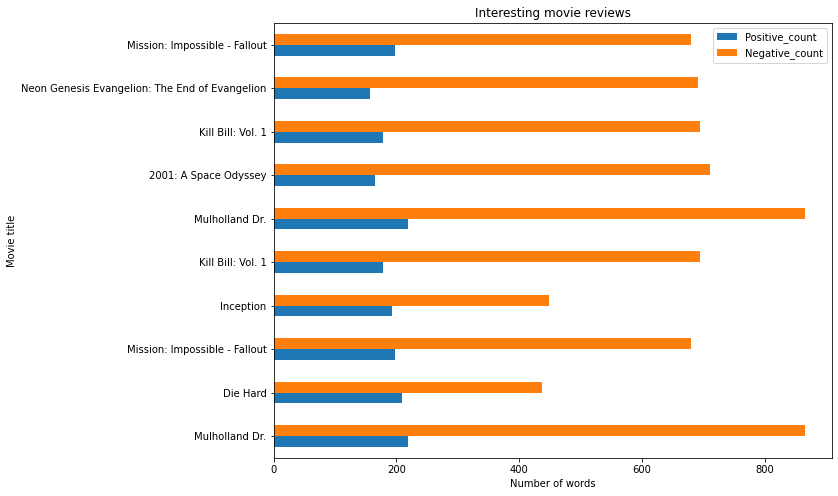

In [ ]:
#interesting reviews
# Ten largest values in column Weight
top_positive = Reviewdata.nlargest(5, ['Positive_count'])
top_negative = Reviewdata.nlargest(5, ['Negative_count'])
filtereddf = pd.concat([top_positive,top_negative])

#plot number of positive and negative words and corresponding movie titles on the graph

filtereddf.plot(x="title", y=["Positive_count", "Negative_count"], kind="barh",figsize=(10,8))
plt.xlabel('Number of words')
plt.ylabel('Movie title')
plt.title('Interesting movie reviews')

# Finding Movie Recommendations

In [ ]:
#!pip install rake_nltk
from rake_nltk import Rake
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

import re
from string import punctuation
from textblob import TextBlob
from nltk import stem
from nltk.corpus import stopwords
import nltk
#nltk.download('all')
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer

# Based on Content

In [ ]:
Reviewdata.head()

,title,review,sentiment,genre,plot,rating,review_clean,Positive_count,Negative_count,Interesting/Uninteresting,review_keywords,movie_keywords
0,Once Upon a Time in America,"Many people compare ""Once Upon a Time in Ameri...",positive,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4,many people compare upon time america godfathe...,77,162,Interesting,"america, many, people, compare, upon, time, go...","guilt, even, self, worn, leather, suitcase, re..."
1,Once Upon a Time in America,... Directors of all time. Let's start with a ...,negative,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4,directors time lets start story many years ago...,81,250,Interesting,"upon, time, america, directors, lets, start, s...","guilt, even, self, worn, leather, suitcase, re..."
2,Once Upon a Time in America,Simply the best movie ever made. Dot.Life. Lov...,positive,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4,simply best movie ever made dotlife love frien...,28,50,Uninteresting,"america, simply, best, movie, ever, made, dotl...","guilt, even, self, worn, leather, suitcase, re..."
3,Once Upon a Time in America,Once Upon a Time in America is Sergio Leone's ...,negative,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4,upon time america sergio leones epic tale live...,88,334,Interesting,"america, upon, time, sergio, leones, epic, tal...","guilt, even, self, worn, leather, suitcase, re..."
4,American Psycho,The author of the novel and the director of th...,positive,"Comedy, Crime, Drama",It's the late 1980s. Twenty-seven year old Wal...,7.6,author novel director film say head yuppies dr...,14,36,Uninteresting,"american, psycho, author, novel, director, fil...","always, late, 1980s, others, unlike, proverbia..."


In [ ]:
Reviewdata['movie_keywords'] = ''
r = Rake()
for index, row in Reviewdata.iterrows():
    r.extract_keywords_from_text(row['title'] + ' ' + row['genre'] + ' ' + row['plot'])
    key_words_dict_scores = r.get_word_degrees()

    Reviewdata.at[index, 'movie_keywords'] = ', '.join(list(key_words_dict_scores.keys())) + ' ' + row['genre'] + ', ' + row['title']
    #Reviewdata.at[index, 'movie_keywords'] = 'asasfasdf'

In [ ]:
# Gets recommendations based on how well passed search text matches movie data
def get_recs(search_string, title=''):
  count = CountVectorizer()
  count_matrix = count.fit_transform(Reviewdata['movie_keywords'])
  cosine_sim = cosine_similarity(count_matrix, count_matrix)

  recommendations = {}
  
  idx = Reviewdata.index[Reviewdata['title'] == title][0]
  #print(idx)

  #idx = indices[indices == title].index[0] 
  score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
  #print(score_series)
  top_10_indices = list(score_series.iloc[1:11].index)
    # Returns the top 10 best matches in order of how closely they match 
  #print('test')
  for i in top_10_indices:
    #rec_title = Reviewdata['title']
    recommendations[Reviewdata['title'][i]] = Reviewdata['rating'][i]
  
  return(recommendations)

def recommend_by_movie_data(title):
  #print(title)
  #print(Reviewdata.loc[Reviewdata['title'] == title])
  search_string = Reviewdata['movie_keywords']
  #print(search_string)
  recs = get_recs(search_string, title)
  return(recs)

In [ ]:
model1_recs = recommend_by_movie_data('Once Upon a Time in America')
model1_recs

{"Dead Man's Shoes": 7.6,
 'Once Upon a Time in America': 8.4,
 'Once Upon a Time in Anatolia': 7.9}

# Based on Reviews

In [ ]:
interesting_df = Reviewdata.loc[ Reviewdata['Interesting/Uninteresting'] == 'Interesting'] # removing "unhelpful" reviews so they don't inform search results
interesting_df.head()

,title,review,sentiment,genre,plot,rating,review_clean,Positive_count,Negative_count,Interesting/Uninteresting,review_keywords
0,Once Upon a Time in America,"Many people compare ""Once Upon a Time in Ameri...",positive,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4,many people compare upon time america godfathe...,77,162,Interesting,"america, many, people, compare, upon, time, go..."
1,Once Upon a Time in America,... Directors of all time. Let's start with a ...,negative,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4,directors time lets start story many years ago...,81,250,Interesting,"upon, time, america, directors, lets, start, s..."
3,Once Upon a Time in America,Once Upon a Time in America is Sergio Leone's ...,negative,"Crime, Drama",With the vivid memory of his long-gone childho...,8.4,upon time america sergio leones epic tale live...,88,334,Interesting,"america, upon, time, sergio, leones, epic, tal..."
9,The Notebook,"Heartwarming, heart-wrenching, poignant, emoti...",negative,"Drama, Romance","In a nursing home, resident Duke reads a roman...",7.8,heartwarming heartwrenching poignant emotional...,91,369,Interesting,"notebook, heartwarming, heartwrenching, poigna..."
11,The Notebook,I like Rachel McAdams and Joan Allen. They act...,negative,"Drama, Romance","In a nursing home, resident Duke reads a roman...",7.8,like rachel mcadams joan allen acted well coul...,27,143,Interesting,"notebook, like, rachel, mcadams, joan, allen, ..."


In [ ]:
Reviewdata['review_keywords'] = ''
r = Rake()
for index, row in Reviewdata.iterrows():
    r.extract_keywords_from_text(row['title'] + ' ' + row['review_clean'])
    key_words_dict_scores = r.get_word_degrees()

    Reviewdata.at[index, 'review_keywords'] = ', '.join(list(key_words_dict_scores.keys()))



In [ ]:
count = CountVectorizer()
count_matrix = count.fit_transform(interesting_df['review_keywords'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)
print(cosine_sim)

[[1.         0.23036972 0.19354735 ... 0.12716702 0.11233673 0.05973378]
 [0.23036972 1.         0.16677507 ... 0.09248166 0.09258924 0.03829255]
 [0.19354735 0.16677507 1.         ... 0.09006062 0.09944712 0.0423039 ]
 ...
 [0.12716702 0.09248166 0.09006062 ... 1.         0.0591904  0.03996676]
 [0.11233673 0.09258924 0.09944712 ... 0.0591904  1.         0.07502486]
 [0.05973378 0.03829255 0.0423039  ... 0.03996676 0.07502486 1.        ]]


In [ ]:
# Gets recommendations based on how well passed search text matches existing helpful reviews
def get_recs(search_string, title=''):

  rec_df = interesting_df.drop(interesting_df[interesting_df['title'] == title].index) # drops the movie currentnly being searched for to avoid movies recommending themselves
  new_row = {'title': title, 'review':search_string, 'Interesting/Uninteresting':'Interesting', 'review_keywords': search_string} # creates 

  rec_df = rec_df.append(new_row, ignore_index = True)

  count = CountVectorizer()
  count_matrix = count.fit_transform(rec_df['review_keywords'])
  cosine_sim = cosine_similarity(count_matrix, count_matrix)

  pos_movies = []
  neg_movies = []
  idx = rec_df.index[rec_df['title'] == title][0]


  #idx = indices[indices == title].index[0] 
  score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
  top_10_indices = list(score_series.iloc[1:11].index)
    # Returns the top 10 best matches in order of how closely they match 
  for i in top_10_indices:
    if (Reviewdata['sentiment'])[i] == 'positive':
      pos_movies.append(Reviewdata['title'][i])
    else:
      neg_movies.append(Reviewdata['title'][i])
    
  pos_movies = set(pos_movies)
  neg_movies = set(neg_movies)

  print('Movies with good reviews matching your interests:' )
  print(pos_movies) 
  print('Movies with mixed reviews matching your interests: ' )
  print(neg_movies)

  return([pos_movies, neg_movies])

def recommend_by_movie(title):
  #print(interesting_df.loc[interesting_df['title'] == title]['review_keywords'].sum())
  search_string = interesting_df.loc[interesting_df['title'] == title]['review_keywords'].sum() + title
  recs = get_recs(search_string, title)
  return recs

In [ ]:
get_recs('that one movie where the iguana wearing clown shoes learns to kickbox')

Movies with good reviews matching your interests:
{'Deliverance', 'Mulan', 'Patton', 'Donnie Brasco'}
Movies with mixed reviews matching your interests: 
{'The Fault in Our Stars', 'The Sixth Sense', 'Fantastic Mr. Fox', 'The Gentlemen', 'Jaws', 'American Psycho'}


In [ ]:
recs = recommend_by_movie('Once Upon a Time in America')
good_fits = recs[0]
iffy_fits = recs[1]

Movies with good reviews matching your interests:
{'Zodiac', 'Wind River', 'Battle Royale', 'Fantastic Mr. Fox', 'Toy Story 3'}
Movies with mixed reviews matching your interests: 
{'Memento', 'Portrait of a Lady on Fire', 'Mulan', 'Manchester by the Sea', 'Whiplash'}


# Model Comparison

In [ ]:
# Results from searching for movie data
dict(sorted(model1_recs.items(), key=lambda item: item[1]))

{"Dead Man's Shoes": 7.6,
 'Once Upon a Time in America': 8.4,
 'Once Upon a Time in Anatolia': 7.9}

In [ ]:
# Results from searching for reviews
good_fits.union(iffy_fits)

{'Battle Royale',
 'Fantastic Mr. Fox',
 'Manchester by the Sea',
 'Memento',
 'Mulan',
 'Portrait of a Lady on Fire',
 'Toy Story 3',
 'Whiplash',
 'Wind River',
 'Zodiac'}

In [ ]:
texts = ['"I want a movie about lemurs!"', 'this movie is about explosions', 'this one is about romance', 'this one has romantic explosions', 'this movie is about exploding lemurs']


df = pd.DataFrame({'texts': texts})
df


,texts
0,"""I want a movie about lemurs!"""
1,this movie is about explosions
2,this one is about romance
3,this one has romantic explosions
4,this movie is about exploding lemurs


In [ ]:
count = CountVectorizer()
count_matrix = count.fit_transform(df['texts'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)
print(cosine_sim)
print(count_matrix)

[[1.         0.4472136  0.2236068  0.         0.61237244]
 [0.4472136  1.         0.6        0.4        0.73029674]
 [0.2236068  0.6        1.         0.4        0.54772256]
 [0.         0.4        0.4        1.         0.18257419]
 [0.61237244 0.73029674 0.54772256 0.18257419 1.        ]]
  (0, 0)	1
  (0, 5)	1
  (0, 6)	1
  (0, 11)	1
  (1, 0)	1
  (1, 2)	1
  (1, 4)	1
  (1, 6)	1
  (1, 10)	1
  (2, 0)	1
  (2, 4)	1
  (2, 7)	1
  (2, 8)	1
  (2, 10)	1
  (3, 2)	1
  (3, 3)	1
  (3, 7)	1
  (3, 9)	1
  (3, 10)	1
  (4, 0)	1
  (4, 1)	1
  (4, 4)	1
  (4, 5)	1
  (4, 6)	1
  (4, 10)	1
